In [1]:
import os
import math
import random
import numpy as np
import tensorflow as tf
import cv2
slim = tf.contrib.slim
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
sys.path.append('../')
from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
from notebooks import visualization

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
class SSD300:
    def __init__(self):
        self.isess = tf.InteractiveSession(config = tf.ConfigProto(log_device_placement = False, 
                                                                   gpu_options          = tf.GPUOptions(allow_growth = True)))
        self.__build__()
    def __build__(self):
        self.img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
        image_pre, _, _, self.bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(self.img_input, 
                                                                                   None, 
                                                                                   None, 
                                                                                   (300, 300), 
                                                                                   'NHWC', 
                                                                                   resize = ssd_vgg_preprocessing.Resize.WARP_RESIZE)
        self.image_4d = tf.expand_dims(image_pre, 0)
        # Define the SSD model.
        ssd_net = ssd_vgg_300.SSDNet()
        with slim.arg_scope(ssd_net.arg_scope(data_format='NHWC')):
            self.predictions, self.localisations, _, _ = ssd_net.net(self.image_4d, 
                                                                     is_training=False, 
                                                                     reuse=(True, None)['ssd_net' in locals()])
        # Restore SSD model.
        ckpt_filename = '../checkpoints/ssd_300_vgg.ckpt'
        self.isess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        saver.restore(self.isess, ckpt_filename)
        # SSD default anchor boxes.
        self.ssd_anchors = ssd_net.anchors((300, 300))
    def pred(self, 
             img, 
             select_threshold=0.5, 
             nms_threshold=.45):
        # Run SSD network.
        rimg, rpredictions, rlocalisations, rbbox_img = self.isess.run([self.image_4d, 
                                                                        self.predictions, 
                                                                        self.localisations, 
                                                                        self.bbox_img],
                                                                       feed_dict = {self.img_input: img})
        # Get classes and bboxes from the net outputs.
        rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(rpredictions, 
                                                                  rlocalisations, 
                                                                  self.ssd_anchors,
                                                                  select_threshold = select_threshold, 
                                                                  img_shape        = (300, 300), 
                                                                  num_classes      = 21, 
                                                                  decode           = True)

        rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
        rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, 
                                                            rscores, 
                                                            rbboxes, 
                                                            top_k = 400)
        rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, 
                                                           rscores, 
                                                           rbboxes, 
                                                           nms_threshold = nms_threshold)
        # Resize bboxes to original image shape. Note: useless for Resize.WARP!
        rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
        return rclasses, rscores, rbboxes, rimg

In [3]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!


## SSD 300 Model

The SSD 300 network takes 300x300 image inputs. In order to feed any image, the latter is resize to this input shape (i.e.`Resize.WARP_RESIZE`). Note that even though it may change the ratio width / height, the SSD model performs well on resized images (and it is the default behaviour in the original Caffe implementation).

SSD anchors correspond to the default bounding boxes encoded in the network. The SSD net output provides offset on the coordinates and dimensions of these anchors.

## Post-processing pipeline

The SSD outputs need to be post-processed to provide proper detections. Namely, we follow these common steps:

* Select boxes above a classification threshold;
* Clip boxes to the image shape;
* Apply the Non-Maximum-Selection algorithm: fuse together boxes whose Jaccard score > threshold;
* If necessary, resize bounding boxes to original image shape.

In [4]:
# Test on some demo image and visualize output.
path = '../demo/'
image_names = sorted(os.listdir(path))
print(image_names)

['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000006.jpg', '000008.jpg', '000010.jpg', '000022.jpg', 'car.jpg', 'coppelia.JPG', 'dog.jpg', 'eagle.jpg', 'horses.jpg', 'person.jpg', 'street.jpg']


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.dropout instead.
INFO:tensorflow:Restoring parameters from ../checkpoints/ssd_300_vgg.ckpt


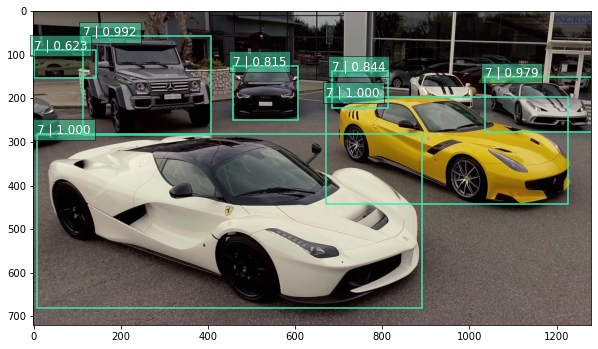

In [5]:

img = mpimg.imread(path + image_names[-7])
ssd300 = SSD300()
rclasses, rscores, rbboxes, rimg =  ssd300.pred(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

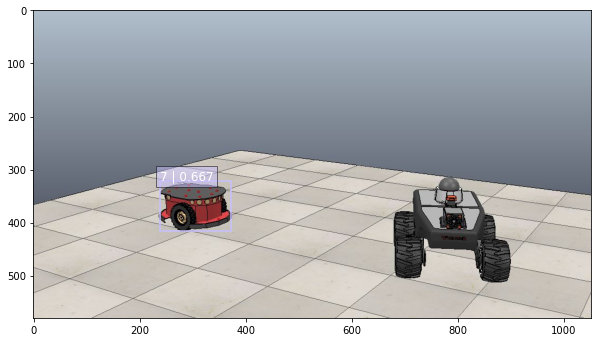

In [6]:

img = mpimg.imread(path + image_names[-6])
rclasses, rscores, rbboxes, rimg =  ssd300.pred(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

In [7]:
import random
class CV2BBoxes:
    def __init__(self):
        self.colors    = {}
        self.linewidth = 2
    def draw(self, img, classes, scores, bboxes):
        height = img.shape[0]
        width  = img.shape[1]
        for i in range(classes.shape[0]):
            cls_id = int(classes[i])
            if cls_id >= 0 and cls_id not in self.colors:
                self.colors[cls_id] = (random.randint(0, 255), 
                                       random.randint(0, 255), 
                                       random.randint(0, 255))
                ymin = int(bboxes[i, 0] * height)
                xmin = int(bboxes[i, 1] * width)
                ymax = int(bboxes[i, 2] * height)
                xmax = int(bboxes[i, 3] * width)
                cv2.rectangle(img, 
                              (xmin, ymin), 
                              (xmax, ymax),
                              self.colors[cls_id],
                              self.linewidth)
                cv2.putText(img, 
                            f'{cls_id} | {scores[i]:.3f}',
                            (xmin, ymin - 2),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.5,
                            self.colors[cls_id],
                            self.linewidth)
        print(self.colors)
        return img
    def show(self, img, classes, scores, bboxes):
        img = self.draw(img, classes, scores, bboxes)
        cv2.imshow("frame", img); cv2.waitKey(1);

In [8]:
cv2_bboxes = CV2BBoxes()

In [9]:
cv2_bboxes.show(img, rclasses, rscores, rbboxes)

{7: (80, 88, 123)}
